In [58]:
import dask.dataframe as dd
import dask_geopandas
from shapely.geometry import Point

# Read the CSV file into a Dask DataFrame
ddf = dd.read_csv('data/elevation_data_downsampled.csv')

# Function to process each partition
def process_partition(pdf):
    # Remove parentheses
    pdf['coordinates'] = pdf['coordinates'].str.replace('[()]', '', regex=True)
    # Split the 'coordinates' column into 'latitude' and 'longitude'
    coords_split = pdf['coordinates'].str.split(', ', n=1, expand=True)
    pdf['latitude'] = coords_split[0].astype(float)
    pdf['longitude'] = coords_split[1].astype(float)
    # Create a 'geometry' column with Shapely Points
    pdf['geometry'] = [Point(lon, lat) for lat, lon in zip(pdf['latitude'], pdf['longitude'])]
    return pdf

# Apply the function to each partition
ddf = ddf.map_partitions(process_partition, meta={
    'coordinates': 'object',
    'elevation (m)': 'float64',
    'latitude': 'float64',
    'longitude': 'float64',
    'geometry': 'object'
})

# Convert to a Dask GeoDataFrame
ddf = dask_geopandas.from_dask_dataframe(ddf)

# # Set the Coordinate Reference System (CRS) to WGS84 (EPSG:4326)
ddf = ddf.set_geometry(dask_geopandas.points_from_xy(ddf, 'longitude', 'latitude'))
ddf = ddf.set_crs("EPSG:4326")

# # Verify the transformation
# print(ddf.head())


In [59]:
ddf.head()

,coordinates,elevation (m),latitude,longitude,geometry
0,"34.999861, -119.999861",1338,34.999861,-119.999861,POINT (-119.99986 34.99986)
1,"34.999861, -119.999305",1323,34.999861,-119.999305,POINT (-119.9993 34.99986)
2,"34.999861, -119.998750",1300,34.999861,-119.998750,POINT (-119.99875 34.99986)
3,"34.999861, -119.998194",1274,34.999861,-119.998194,POINT (-119.99819 34.99986)
4,"34.999861, -119.997639",1255,34.999861,-119.997639,POINT (-119.99764 34.99986)


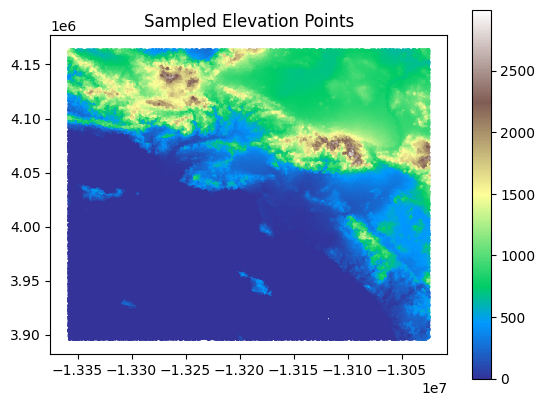

In [78]:
import matplotlib.pyplot as plt

sample = ddf.sample(frac=0.01).compute()  # sample 1% for quick plot
sample.plot(column='elevation (m)', cmap='terrain', markersize=1, legend=True)
plt.title("Sampled Elevation Points")
plt.show()

In [81]:
gdf = ddf.compute()

# Get bounds: [min_lon, min_lat, max_lon, max_lat]
minx, miny, maxx, maxy = gdf.total_bounds

# Print or use in pydeck
print("Bounding Box:")
print(f"Min Longitude: {minx}")
print(f"Min Latitude: {miny}")
print(f"Max Longitude: {maxx}")
print(f"Max Latitude: {maxy}")

Bounding Box:
Min Longitude: -13358323.421783607
Min Latitude: 3895322.4133335967
Max Longitude: -13024395.89622223
Max Latitude: 4163862.254535559


In [ ]:
gdf

,coordinates,elevation (m),latitude,longitude,geometry,x,y,grid_x,grid_y,grid_id
0,"34.999861, -119.999861",1338,34.999861,-119.999861,POINT (-13358323.422 4163862.255),-1.335832e+07,4.163862e+06,-13360000.0,4160000.0,-13360000.0_4160000.0
1,"34.999861, -119.999305",1323,34.999861,-119.999305,POINT (-13358261.528 4163862.255),-1.335826e+07,4.163862e+06,-13360000.0,4160000.0,-13360000.0_4160000.0
2,"34.999861, -119.998750",1300,34.999861,-119.998750,POINT (-13358199.746 4163862.255),-1.335820e+07,4.163862e+06,-13360000.0,4160000.0,-13360000.0_4160000.0
3,"34.999861, -119.998194",1274,34.999861,-119.998194,POINT (-13358137.852 4163862.255),-1.335814e+07,4.163862e+06,-13360000.0,4160000.0,-13360000.0_4160000.0
4,"34.999861, -119.997639",1255,34.999861,-119.997639,POINT (-13358076.07 4163862.255),-1.335808e+07,4.163862e+06,-13360000.0,4160000.0,-13360000.0_4160000.0
...,...,...,...,...,...,...,...,...,...,...
2236704,"33.000139, -117.002361",351,33.000139,-117.002361,POINT (-13024643.248 3895322.413),-1.302464e+07,3.895322e+06,-13030000.0,3890000.0,-13030000.0_3890000.0
2236705,"33.000139, -117.001806",347,33.000139,-117.001806,POINT (-13024581.466 3895322.413),-1.302458e+07,3.895322e+06,-13030000.0,3890000.0,-13030000.0_3890000.0
2236706,"33.000139, -117.001250",346,33.000139,-117.001250,POINT (-13024519.572 3895322.413),-1.302452e+07,3.895322e+06,-13030000.0,3890000.0,-13030000.0_3890000.0
2236707,"33.000139, -117.000695",357,33.000139,-117.000695,POINT (-13024457.79 3895322.413),-1.302446e+07,3.895322e+06,-13030000.0,3890000.0,-13030000.0_3890000.0


In [83]:
min_lat = gdf['latitude'].min()
max_lat = gdf['latitude'].max()

min_lon = gdf['longitude'].min()
max_lon = gdf['longitude'].max()

print("Latitude range:", min_lat, "to", max_lat)
print("Longitude range:", min_lon, "to", max_lon)

Latitude range: 33.000139 to 34.999861
Longitude range: -119.999861 to -117.000139
